<a href="https://colab.research.google.com/github/galbraun/knesset_social_dynamics/blob/master/ERGM_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install rpy2
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [ ]:
%%R
install.packages('network')
install.packages('ergm')
install.packages('sna')
install.packages('coda')
library(network)
library(ergm)
library(sna)
library(coda)

In [ ]:
%%R
data(package='ergm') # tells us the datasets in our packages
data(florentine) # loads flomarriage and flobusiness data
flomarriage # Let's look at the flomarriage data

 Network attributes:
  vertices = 16 
  directed = FALSE 
  hyper = FALSE 
  loops = FALSE 
  multiple = FALSE 
  bipartite = FALSE 
  total edges= 20 
    missing edges= 0 
    non-missing edges= 20 

 Vertex attribute names: 
    priorates totalties vertex.names wealth 

No edge attributes


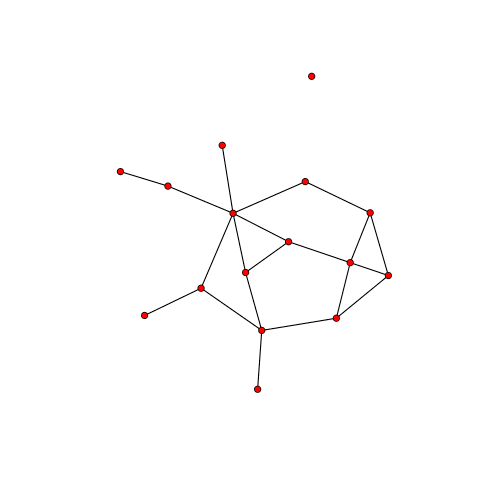

In [ ]:
%%R
plot(flomarriage) # Let's view the flomarriage network

In [ ]:
%%R
flomodel.01 <- ergm(flomarriage~edges) # fit model

R[write to console]: Starting maximum pseudolikelihood estimation (MPLE):

R[write to console]: Evaluating the predictor and response matrix.

R[write to console]: Maximizing the pseudolikelihood.

R[write to console]: Finished MPLE.

R[write to console]: Stopping at the initial estimate.

R[write to console]: Evaluating log-likelihood at the estimate. 
R[write to console]: 



In [ ]:
%%R
print(flomodel.01)
summary(flomodel.01) # look in more depth


MLE Coefficients:
 edges  
-1.609  

Summary of model fit

Formula:   flomarriage ~ edges

Iterations:  5 out of 20 

Monte Carlo MLE Results:
      Estimate Std. Error MCMC % z value Pr(>|z|)    
edges  -1.6094     0.2449      0  -6.571   <1e-04 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

     Null Deviance: 166.4  on 120  degrees of freedom
 Residual Deviance: 108.1  on 119  degrees of freedom
 
AIC: 110.1    BIC: 112.9    (Smaller is better.) 
